# Introduction
- 멀리 있는 물체가 빙하 또는 선박인지 확인하는 모델을 만들어 보자.

In [1]:
# import module
import numpy as np
import pandas as pd
from subprocess import check_output
from sklearn.model_selection import train_test_split, StratifiedKFold
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

Loading Data

In [2]:
train = pd.read_json('/content/drive/My Drive/Kaggle/Iceberg Classification/train.json')
test = pd.read_json('/content/drive/My Drive/Kaggle/Iceberg Classification/test.json')

#Data at one sight

데이터에 대한 설명이 처음에 주어졌다. 
- id : id of the image
- band_1, band_2 : the flatted image data. 75*75 pixel values. Band1, Band2 는 radar backscatter로 특징지어진 신호다. 여기에 두 가지 value가 있다. HH(transmit/recieve horizontally), HV(transmit horizontally and receive vertically).
- inc_angle : the incidence angle of which the image was taken. missing data는 na로 처리되었다.
- is_iceberg : the target variable, set to 1 if it is and iceberg, and 0 if it is a ship.


In [3]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [4]:
len(train)

1604

In [5]:
test.head()

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


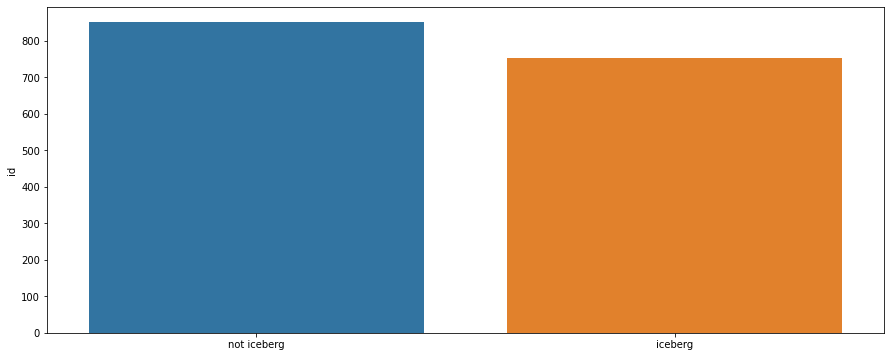

In [6]:
f, ax = plt.subplots(1,1,figsize=(15,6))
sns.barplot(x=['not iceberg', 'iceberg'], y=train.groupby(['is_iceberg'], as_index=False).count()['id'])
plt.show()

- 데이터가 balanced하다

# Plotting some images
- It's good to plot some images before we do. That way, we can get some sense of what we're looking at.

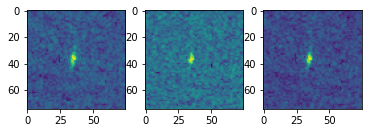

In [7]:
img1 = np.array(train.iloc[0]['band_1']).reshape((75,75))
plt.subplot(1,3,1)
plt.imshow(img1)

plt.subplot(1,3,2)
img2 = np.array(train.iloc[0]['band_2']).reshape((75,75))
plt.imshow(img2)
plt.subplot(1,3,3)
plt.imshow(img1 + img2)

In [8]:
#training data
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train['band_1']])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

y_train = train['is_iceberg']

In [9]:
#test data
X_band_test_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in test['band_1']])
X_band_test_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test['band_2']])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [10]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')

train['inc_angle'] = train['inc_angle'].fillna(method='pad') # 결측값 주변값으로 채우기
test['inc_angle'] = test['inc_angle'].fillna(method='pad')

X_train_angle = train['inc_angle']
x_test_angle = test['inc_angle']

In [11]:
X_train[0]

array([[[-27.87836 , -27.154118, -27.51624 ],
        [-27.15416 , -29.537888, -28.346024],
        [-28.668615, -31.0306  , -29.849607],
        ...,
        [-25.573483, -29.095308, -27.334396],
        [-26.488674, -29.540878, -28.014776],
        [-30.507013, -27.511766, -29.00939 ]],

       [[-28.66853 , -31.030518, -29.849524],
        [-27.8784  , -33.529335, -30.703869],
        [-27.508776, -31.591175, -29.549976],
        ...,
        [-26.488632, -34.288055, -30.388344],
        [-28.671562, -28.267496, -28.469528],
        [-31.594166, -26.488716, -29.041441]],

       [[-28.66853 , -33.52929 , -31.09891 ],
        [-27.15416 , -37.05116 , -32.10266 ],
        [-25.865042, -31.591175, -28.728107],
        ...,
        [-27.157106, -31.594084, -29.375595],
        [-27.881393, -32.19339 , -30.037392],
        [-32.837124, -29.54092 , -31.189022]],

       ...,

       [[-29.092905, -27.87895 , -28.485928],
        [-28.669163, -27.878992, -28.274078],
        [-30.504612, -

Let's look at more image

# Data Preprocessing

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_train_angle, X_valid_angle, y_train, y_valid = train_test_split(X_train,
                                    X_train_angle, y_train, random_state=42, train_size=0.8)

## Building Model

In [13]:
#import module
import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Layer, Conv2D, MaxPooling2D,GlobalMaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras import initializers
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19

In [16]:
model = keras.models.Sequential()
#conv layer 1
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(75,75,3)))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Dropout(0.2))

#conv layer 2
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

#Conv layer 3
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

#Conv layer 4
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

#You must flatten the data for the dense layer
model.add(Flatten())

#Dense layer1
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#Dense layer 2
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
model.compile(loss='binary_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

In [19]:
def get_callbacks(filepath, patience=2):
  es = EarlyStopping('val_loss', patience=10, mode='min')
  msave = ModelCheckpoint(filepath, save_best_only=True)
  return [es, msave]

file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

## Training Model

In [20]:
import os
model.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/50
41/41 [==============================] - 1s 25ms/step - loss: 1.1542 - accuracy: 0.5160 - val_loss: 0.6594 - val_accuracy: 0.6698
Epoch 2/50
41/41 [==============================] - 1s 16ms/step - loss: 0.5764 - accuracy: 0.6329 - val_loss: 0.5695 - val_accuracy: 0.7040
Epoch 3/50
41/41 [==============================] - 1s 16ms/step - loss: 0.5110 - accuracy: 0.7311 - val_loss: 0.4903 - val_accuracy: 0.7944
Epoch 4/50
41/41 [==============================] - 1s 15ms/step - loss: 0.5150 - accuracy: 0.7256 - val_loss: 0.5221 - val_accuracy: 0.7601
Epoch 5/50
41/41 [==============================] - 1s 16ms/step - loss: 0.4533 - accuracy: 0.7740 - val_loss: 0.4007 - val_accuracy: 0.8100
Epoch 6/50
41/41 [==============================] - 1s 15ms/step - loss: 0.4271 - accuracy: 0.7825 - val_loss: 0.4063 - val_accuracy: 0.8131
Epoch 7/50
41/41 [==============================] - 1s 16ms/step - loss: 0.4059 - accuracy: 0.8059 - val_loss: 0.3746 - val_accuracy: 0.8224
Epoch 8/50
41

# Evaluate model



In [21]:
model.load_weights(filepath=file_path)
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Test loss', score[0])
print('Test accuracy', score[1])

11/11 [==============================] - 0s 7ms/step - loss: 0.3042 - accuracy: 0.8474
Test loss 0.30422085523605347
Test accuracy 0.8473520278930664


- 84.74%의 정확도 0.30의 loss를 얻었다. 

In [26]:
predict_test = model.predict(X_test)
predict_test

array([[1.3824740e-01],
       [5.1285958e-01],
       [4.0762185e-09],
       ...,
       [4.4928849e-02],
       [9.9955374e-01],
       [4.1513722e-03]], dtype=float32)

In [24]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['is_iceberg']=predict_test.reshape((predict_test.shape[0]))
submission.to_csv('sub.csv', index=False)